## Packages

In [447]:
begin
	using Markdown
	using InteractiveUtils
	using CSV
	using DataFrames
	using PhysicalConstants.CODATA2018
	using StatsPlots

	using Formatting
	using Printf
	using StrLiterals
	using StrFormat
	using Format
	using SpecialFunctions

	using HCubature
    using ZipFile
	using LsqFit
	using Plots
	using LaTeXStrings
	using Statistics
	using Dates
	using Unitful
	using UnitfulEquivalences
	using Plots
end


In [448]:
using DrWatson
@quickactivate "/Users/pabloherrero/sabat/LabFBI/"

In [449]:
import Unitful:
    nm, μm, mm, cm, m, km, inch, ft, mi,
    ac,
    mg, g, kg,
    Ra, °F, °C, K,
    rad, °,
    ns, μs, ms, ps, s, minute, hr, d, yr, Hz,
    eV,
    μJ, mJ, J,
	mW, μW, W,
    A, N, mol, mmol, V, L, mL, μL, M

In [450]:
macro bind(def, element)
    quote
        local el = $(esc(element))
        global $(esc(def)) = Core.applicable(Base.get, el) ? Base.get(el) : missing
        el
    end
end

@bind (macro with 1 method)

In [692]:
function ingredients(path::String)
	# this is from the Julia source code (evalfile in base/loading.jl)
	# but with the modification that it returns the module instead of the last object
	name = Symbol(basename(path))
	m = Module(name)
	Core.eval(m,
        Expr(:toplevel,
             :(eval(x) = $(Expr(:core, :eval))($name, x)),
             :(include(x) = $(Expr(:top, :include))($name, x)),
             :(include(mapexpr::Function, x) = $(Expr(:top, :include))(mapexpr, $name, x)),
             :(include($path))))
	m
end

ingredients (generic function with 1 method)

In [691]:
function glaser_md(gl)
	np = lfi.LabFbi.n_photons(gl.λ, gl.P)
	md = " ### Laser \n"
	ll = lti.LabTools.to_fstr(gl.λ/nm,"%5.2g")
	lp = lti.LabTools.to_fstr(gl.P/mW,"%5.2g")
	nnp = lti.LabTools.to_fstr(np/Hz,"%5.2g")
	lw0 = lti.LabTools.to_fstr(gl.w0/mm,"%5.2g")
	lw0 = lti.LabTools.to_fstr(gl.w0/mm,"%5.2g")
	lzr = lti.LabTools.to_fstr(gl.zr/mm,"%5.2g")
	lθ  = lti.LabTools.to_fstr(gl.θr*1e+3,"%5.2g")
	rho = lti.LabTools.to_fstr(gl.ρ0/(Hz* cm^-2),"%5.2g")
	md = string(md, "  - laser λ     = $ll  nm \n")
	md = string(md, "  - laser P     = $lp  mW \n")
	md = string(md, "  - photon rate = $nnp  np  Hz \n")
	md = string(md, "  - laser w0    = $lw0 mm \n")
	md = string(md, "  - laser zr    = $lzr mm \n")
	md = string(md, "  - laser θr    = $lθ  mrad \n")
	md = string(md, "  - photon ρ    = $rho Hz/cm2 \n")
	return md
end

function setup_md(setup, sset)
	md = " ### setup \n"
	ll = lti.LabTools.to_fstr(setup.t/mm,"%5.2g")
	cc = lti.LabTools.to_fstr(setup.C/M,"%5.2g")
	cmol = lti.LabTools.to_fstr(setup.c/mm^-3,"%5.2g")
	dc = lti.LabTools.to_fstr(setup.D/mm,"%5.2g")
	Dc = lti.LabTools.to_fstr(setup.d/mm,"%5.2g")
	md = string(md, "  - molecule            = $sset \n")
	md = string(md, "  - Thickness vase  = $ll  mm \n")
	md = string(md, "  - Concentration   = $cc  M \n")
	md = string(md, "  - Concentration   = $cmol molec/mm^3 \n")
	md = string(md, "  - diameter CCD    = $dc mm  \n")
	md = string(md, "  - distance to CCD = $Dc mm  \n")
	return md
end

function dfinfo(df,nx=2:7)
	function cnames(df, nx)
		return names(df)[nx]
	end
	
	function dflm(df)
		l = df[!, "λ"]
		return l[1], l[end]
	end
	
	function dfc(df, nx=2:7)
		nz = split.(cnames(df,nx),"_")
		cs = [n[2] for n in nz]
		return parse.(Float64, cs) * M
	end
	
	λi, λf = dflm(df)
	cs = dfc(df, nx)
	cn = cnames(df, nx)
	cn1s = split(cn[1],"_")
	lexc = cn1s[3]
	dfname = cn1s[1]
	
	return DfInfo(dfname, lexc, λi, λf, cn, cs)
end

function get_fit(fglm)
	function sline(x)
		return c[1] + c[2] * x
	end
	
	c = coef(fglm)
	return sline
end

function r_θ(θr, z)
	return θr * z * 2.0
end

begin
	lfi = ingredients(srcdir("LabFbi.jl"))
	lti = ingredients(srcdir("LabTools.jl"))
	lpi = ingredients(srcdir("LabPlots.jl"))
end

struct Setup
	C::typeof(1.0M)         # concentration (in M)
	c::typeof(1.0mm^-3)    # concentration (in molecules/mm3)
	t::typeof(1.0mm)       # thickness of vase
	d::typeof(1.0mm)       # diameter of CCD
	D::typeof(1.0mm)       # Distance between CCD and vase
end


In [453]:
exp(-(gl.zr * tan(α)/gl.w0)^2)

4.9279889052568465e-155

In [454]:
gl.zr, gl.w0, (gl.zr * tan(α)/gl.w0)^2

(0.08143008158104742 mm, 0.00324 mm, 355.30575843921673)

In [835]:

function fluorescence_rate2(gl, fl, t, C)
	p = lfi.LabFbi.n_photons(gl.λ, gl.P)
	return uconvert(Hz, p * fl.σ * fl.Q * t * C)
end

function focus_fluorescence_rate(gl, fl, ob, t, C)
	p = lfi.LabFbi.n_photons(gl.λ, gl.P)
	α = asin(ob.NA)
	# I = p * fl.σ * fl.Q * C * t * (1 - exp(-(gl.zr * tan(α)/gl.w0)^2))
	I = p * fl.σ * fl.Q * C * t * (1 - exp(-2))

	return uconvert(Hz, I)
end


function rate_prediction(gl,setup, sset, eff_ccdFilters)
	ob = lfi.LabFbi.Objective("x100", 0.6, 100)
	obga = lfi.LabFbi.transmission(ob)

	if sset == "FBI"
		cdf = lfi.LabFbi.load_df_from_csv(datadir("fbi"),
	                          "molar_extinction_coefficient_G1G2.csv", 
	                          lfi.LabFbi.enG) 
		fl = lfi.LabFbi.fbi_fluorophores(cdf, ["g1", "g2"], [325,405], [0.67,0.67])
		fr = fluorescence_rate2(gl, fl.fbi["l405g1"], setup.t, setup.c)

	else
		cdf = lfi.LabFbi.load_df_from_csv(datadir("RuIr"),
	                          "molar_extinction_coefficient_RuIr.csv", 
	                          lfi.LabFbi.enG) 
		fl = lfi.LabFbi.iru_fluorophores(cdf, 
	                       ["IrF", "Ir", "Ru", "IrF+","Ir+","Ru++"],
				           [300,405],
				           [Q,Q,Q,Q,Q, Q])
		# fr = fluorescence_rate2(gl, fl["l405Ru++"], setup.t, setup.c)
		fr = focus_fluorescence_rate(gl, fl["l405Ru++"], ob, 0.4*mm, setup.c)

	end

	#ga = lfi.LabFbi.geometrical_acceptance(setup.d/mm, setup.D/mm) # * 5 In case lens 
	
	return fr * obga * eff_ccdFilters
	
			
end

function rate_prediction_power(pp, setup, sset, eff_ccdFilters)
	GL = [lfi.LabFbi.GLaser(λ, p, uconvert(mm, w0f)) for p in pp]
	IFR = [rate_prediction(gl,setup, sset, eff_ccdFilters) for gl in GL]
	return IFR
end

rate_prediction_power (generic function with 1 method)

In [738]:
gl.zr

0.08143008158104742 mm

## Physical parameters

In [457]:
ob = lfi.LabFbi.Objective("x100", 0.6, 100)
obga = lfi.LabFbi.transmission(ob)

0.09999999999999998

In [458]:
markercolors = [:green :orange :black :purple :red  :yellow :brown :white]

1×8 Array{Symbol,2}:
 :green  :orange  :black  :purple  :red  :yellow  :brown  :white

In [459]:
gr(size=(500,500), xtickfontsize=12, ytickfontsize=12, xguidefontsize=14,
    yguidefontsize=14, legendfontsize=10, dpi=100, grid=(:y, :gray, :solid, 2, 0.4));

In [460]:
lz = 12.43
csp = 1e-7    # Concentration
csu = 1.0
cs = csu * csp
dccd = 526.0
Dccd = 13.3
adcpes = 0.48   # Orca Flash V4.0
qadcpes = 0.107  # Orca Quest
adcpes / qadcpes

4.485981308411215

In [461]:
sset = "IrRu"
Q = 0.25
solfbi = lfi.LabFbi.Solution("C = $cs*M", cs*M)
Cmol_mm3 = lfi.LabFbi.nofv(solfbi, 1*mm^3) / mm^3

6.022140759999999e10 mm⁻³

In [462]:
setup = Setup(cs*M, Cmol_mm3, lzr, dccd*mm, Dccd*mm)

Setup(1.0e-7 M, 6.022140759999999e10 mm⁻³, 13.3 mm, 526.0 mm, 13.3 mm)

## Laser

In [463]:
f = 2*mm
w0f = 2*f*λ/w0
w0f

3240.0 nm

In [640]:
π * w0f^2 / λ

81430.08158104743 nm

In [639]:
gl.zr

0.08143008158104742 mm

In [517]:
begin
    ll = 405.0
    lp = 0.1
    lw0 = 0.5
    lz = 13.3
    tr = 0.26e-3
    ph0 = 5.5

    λ = ll*nm
    P = lp * mW
    w0 = lw0 * mm
    lzr = lz * mm
    
    f = 2*mm
    w0f = 2*f*λ/w0

    gl = lfi.LabFbi.GLaser(λ, P, uconvert(mm, w0f));
    ginfo = glaser_md(gl)
    Markdown.parse("$ginfo")
end

### Laser

  * laser λ     = 4.1e+02  nm
  * laser P     =   0.1  mW
  * photon rate = 2e+14  np  Hz
  * laser w0    = 0.0032 mm
  * laser zr    = 0.081 mm
  * laser θr    =    40  mrad
  * photon ρ    = 1.2e+21 Hz/cm2


### Laser divergence

In [231]:
rxθ = r_θ(gl.θr, lzr);
xgI = lfi.LabFbi.Iρ(gl);
xr = xgI(1.0mm, 0.0mm) / xgI(0.0mm, 0.0mm)
xr2 = xgI(0.5mm, 0.0mm) / xgI(0.0mm, 0.0mm)

0.1353352832366127

In [232]:
begin
	xRmm =collect(-2.0:0.01:2.0)*mm
	xprz0 = lpi.LabPlots.plot_xy(xRmm/mm, xgI.(xRmm,(0.0*mm),)/(Hz*cm^-2), "r (mm)", 
	                "I(r,0) (Hz*cm^-2) ",
	                "I(r,0) for beam");
	xprz1 = lpi.LabPlots.plot_xy(xRmm/mm, xgI.(xRmm,(1.0*mm),)/(Hz*cm^-2), "r (mm)", 
	                "I(r,1mm) (Hz*cm^-2) ",
	                "I(r,1mm) for beam");
	xprz2 = lpi.LabPlots.plot_xy(xRmm/mm, xgI.(xRmm,(5.0*mm),)/(Hz*cm^-2), "r (mm)", 
	                "I(r,5mm) (Hz*cm^-2) ",
	                "I(r,5mm) for beam");
	xprz3 = lpi.LabPlots.plot_xy(xRmm/mm, xgI.(xRmm,(10.0*mm),)/(Hz*cm^-2), "r (mm)", 
	                "I(r,10mm) (Hz*cm^-2) ",
	                "I(r,10mm) for beam");
	nothing
end

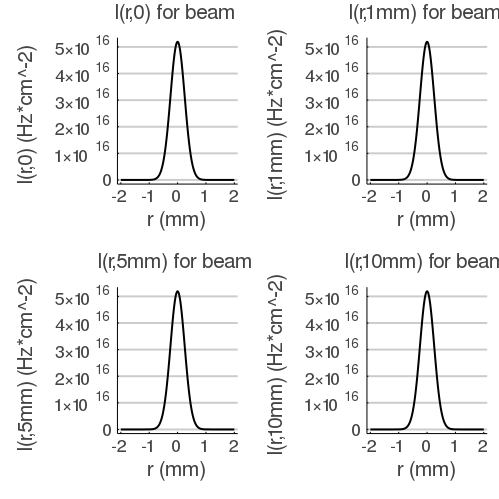

In [233]:
plot(xprz0,xprz1,xprz2,xprz3, layout = (2, 2), legend=false, fmt = :png)

In [16]:
setup = Setup(cs*M, Cmol_mm3, lzr, dccd*mm, Dccd*mm)
sinfo = setup_md(setup, sset)
Markdown.parse("$sinfo")

### setup

  * molecule            = IrRu
  * Thickness vase  =    13  mm
  * Concentration   = 1e-05  M
  * Concentration   = 6e+12 molec/mm^3
  * diameter CCD    =    13 mm
  * distance to CCD = 5.3e+02 mm


## CCD and fluorophore

In [465]:
qOrca = lfi.LabFbi.load_df_from_csv(datadir("filters"), "OrcaQuest_QE.csv", lfi.LabFbi.enG);
# qOrca = lfi.LabFbi.qccd()

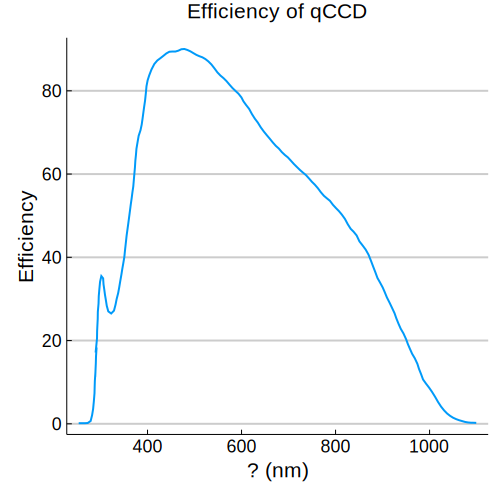

In [466]:
begin
    xL = qOrca["λ (nm)"]
    xEff = qOrca["QE"]
    porca = Plots.plot(xL, xEff, leg=false, lw=2);

    xlabel!("λ (nm)")
    ylabel!("Efficiency")
    title!("Efficiency of qCCD")
end

### Emission spectra

In [467]:
struct DfInfo
	name::String
	λex ::String
	λi::Float64
	λf::Float64
	CN::Array{String}
# 	C::Array{typeof(1.0M)}
end

In [468]:
function dfinfo(df,nx=2:7)
	function cnames(df, nx)
		return names(df)[nx]
	end
	
	function dflm(df)
		l = df[!, "λ"]
		return l[1], l[end]
	end
	
	function dfc(df, nx=2:7)
		nz = split.(cnames(df,nx)," ")
		cs = [n[2] for n in nz]
# 		return parse.(Float64, cs) * M
        return cs
	end
	
	λi, λf = dflm(df)
	cs = dfc(df, nx)
	cn = cnames(df, nx)
	cn1s = split(cn[1]," ")
	lexc = "405."
	dfname = "RuIr solution"
	
	return DfInfo(dfname, lexc, λi, λf, cn)
end

dfinfo (generic function with 2 methods)

In [469]:
ru405df = lfi.LabFbi.load_df_from_csv(datadir("fluorimeter/RuIrPy"), "RuIr_emission_sol.csv", lfi.LabFbi.enG);

In [470]:
dfi = dfinfo(ru405df, 2:7)
dfi

DfInfo("RuIr solution", "405.", 420.0, 900.0, [" IrF", " Ir", " Ru", " IrF+", " Ir+", " Ru++"])

In [555]:
gfru405 = lfi.LabFbi.dftogf(dfi.λi:2.0:dfi.λf, ru405df, dfi.CN[3]);

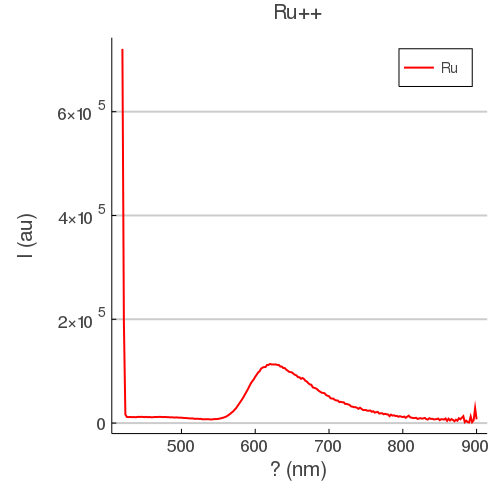

In [472]:
begin 
    dfi = dfinfo(ru405df, 2:7)
    pru405 = lpi.LabPlots.plotdf_xys(ru405df, "λ", dfi.CN[3:3], false, dfi.CN[3:3],
                                    markercolors,
                                    "λ(nm)", "I (au)", "Ru++", legend=:topright )
    
  pgfru405 =lpi.LabPlots.plotdf_gfs([gfru405], dfi.λi:2.0:dfi.λf,[dfi.CN[3]], 
	                              pdf=false,
	                              [:red], "λ (nm)", "I (au)", "Ru++",
		                          legend=:topright)
end

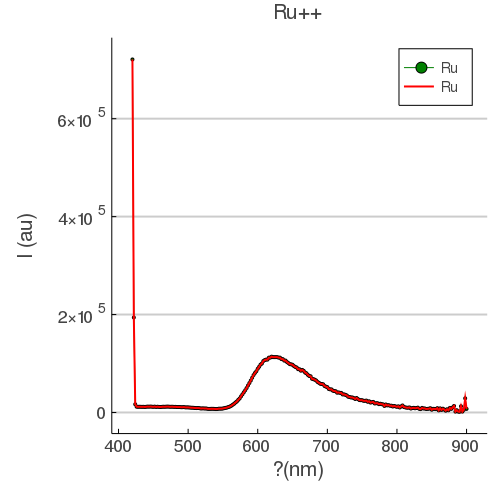

In [473]:
prux = lpi.LabPlots.merge_plots!(pru405, pgfru405)

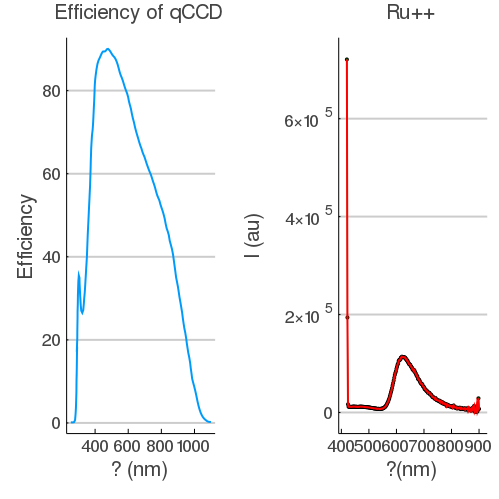

In [474]:
begin
    #     using Plots
        Plots.plot(porca,prux, layout=(1,2), legend=false, fmt=:png)
    end

In [557]:
lfi.LabFbi.qpdf(gfru405.pdf, dfi.λi, dfi.λf)

0.9999999999999988

In [561]:
qorca = lfi.LabFbi.qccd()
qεccd(λ) = map(x->qorca(x) * gfru405.pdf(x), λ)
eff_qccd = lfi.LabFbi.qpdf(qεccd, dfi.λi, dfi.λf)

0.713069713624005

### Repeat for FUSION sCMOS

In [558]:
orca = lfi.LabFbi.ccd()
εccd(λ) = map(x->orca(x) * gfru405.pdf(x), λ)
eff_ccd = lfi.LabFbi.qpdf(εccd, dfi.λi, dfi.λf)

0.7271828503404991

## Filters

In [693]:
lfi.LabFbi.fnames

6-element Array{String,1}:
 "BandPass405"
 "LongPass425"
 "BandPass430"
 "LongPass450"
 "DoubleNotch405_522"
 "NF405"

In [694]:
filterd = lfi.LabFbi.get_filters(lfi.LabFbi.fnames, datadir("filters"))

Dict{String,Interpolations.GriddedInterpolation{Float64,1,Float64,Gridded{Linear},Tuple{Array{Float64,1}}}} with 6 entries:
  "LongPass425"        => 2251-element interpolate((::Array{Float64,1},), ::Arr…
  "BandPass405"        => 1101-element interpolate((::Array{Float64,1},), ::Arr…
  "DoubleNotch405_522" => 721-element interpolate((::Array{Float64,1},), ::Arra…
  "LongPass450"        => 5486-element interpolate((::Array{Float64,1},), ::Arr…
  "BandPass430"        => 2401-element interpolate((::Array{Float64,1},), ::Arr…
  "NF405"              => 2401-element interpolate((::Array{Float64,1},), ::Arr…

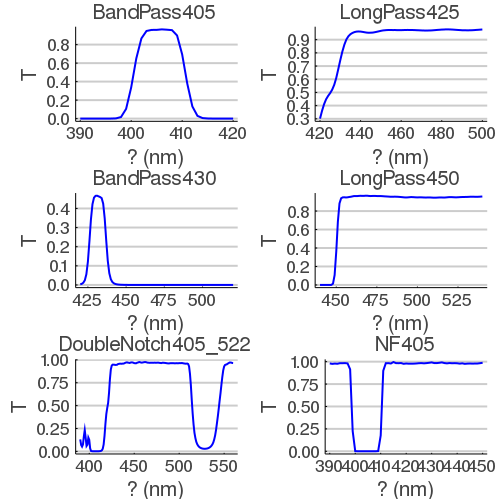

In [695]:
fw = [390:420,420:500,420:520,440:540, 390:560, 390:450]
Pft = lpi.LabPlots.plot_filters(lfi.LabFbi.fnames, filterd, fw);
plot(Pft..., layout=(3,2), legend=false, fmt= :png)

In [696]:
cflt = lfi.LabFbi.common_filters(filterd)

(::Main.LabFbi.jl.LabFbi.var"#cf#19"{Dict{String,Interpolations.GriddedInterpolation{Float64,1,Float64,Gridded{Linear},Tuple{Array{Float64,1}}}}}) (generic function with 1 method)

In [697]:
2*gl.λ/(π*ob.NA), 4*2*mm*gl.λ/(π*w0)

(429.71834634811745 nm, 2062.648062470964 nm)

In [805]:
qεccdFilters(λ) = map(x->cflt(x) * qorca(x)*gfru405.pdf(x), λ)
eff_qccdFilters = lfi.LabFbi.qpdf(qεccdFilters, dfi.λi, dfi.λf)

0.4927795876616403

In [804]:
εccdFilters(λ) = map(x->cflt(x) * orca(x)*gfru405.pdf(x), λ)
eff_ccdFilters = lfi.LabFbi.qpdf(εccdFilters, dfi.λi, dfi.λf)

0.5232005083816411

### Molar Extinction coefficients

In [487]:
cdf = lfi.LabFbi.load_df_from_csv(datadir("RuIr"), "molar_extinction_coefficient_RuIr.csv", lfi.LabFbi.enG)

,λ,ϵIrF,ϵIr,ϵRu,ϵIrF+,ϵIr+,ϵRu++,σIrF,σIr,σRu
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,300,22922,19828,32769,18184,28252,30028,8.76305e-17,7.58022e-17,1.25275e-16
2,405,1716,3256,5251,1053,5806,5326,6.56025e-18,1.24476e-17,2.00745e-17


In [488]:
fl = lfi.LabFbi.iru_fluorophores(cdf, 
	                       ["IrF", "Ir", "Ru", "IrF+","Ir+","Ru++"],
				           [300,405],
				           [Q,Q,Q,Q,Q, Q])

Dict{Any,Any} with 12 entries:
  "l300Ir+"  => Fluorophore("ϵIr+", 300.0 nm, 405.0 nm, 28252.0 cm⁻¹ M⁻¹, 0.25,…
  "l300Ir"   => Fluorophore("ϵIr", 300.0 nm, 405.0 nm, 19828.0 cm⁻¹ M⁻¹, 0.25, …
  "l405Ir"   => Fluorophore("ϵIr", 405.0 nm, 405.0 nm, 3256.0 cm⁻¹ M⁻¹, 0.25, 1…
  "l405Ru++" => Fluorophore("ϵRu++", 405.0 nm, 405.0 nm, 5326.0 cm⁻¹ M⁻¹, 0.25,…
  "l300IrF"  => Fluorophore("ϵIrF", 300.0 nm, 405.0 nm, 22922.0 cm⁻¹ M⁻¹, 0.25,…
  "l405Ir+"  => Fluorophore("ϵIr+", 405.0 nm, 405.0 nm, 5806.0 cm⁻¹ M⁻¹, 0.25, …
  "l300IrF+" => Fluorophore("ϵIrF+", 300.0 nm, 405.0 nm, 18184.0 cm⁻¹ M⁻¹, 0.25…
  "l300Ru"   => Fluorophore("ϵRu", 300.0 nm, 405.0 nm, 32769.0 cm⁻¹ M⁻¹, 0.25, …
  "l405IrF"  => Fluorophore("ϵIrF", 405.0 nm, 405.0 nm, 1716.0 cm⁻¹ M⁻¹, 0.25, …
  "l300Ru++" => Fluorophore("ϵRu++", 300.0 nm, 405.0 nm, 30028.0 cm⁻¹ M⁻¹, 0.25…
  "l405IrF+" => Fluorophore("ϵIrF+", 405.0 nm, 405.0 nm, 1053.0 cm⁻¹ M⁻¹, 0.25,…
  "l405Ru"   => Fluorophore("ϵRu", 405.0 nm, 405.0 nm, 5251.0 cm⁻¹ M⁻¹, 0.25, 

In [489]:
fl["l405Ru++"]

Main.LabFbi.jl.LabFbi.Fluorophore("ϵRu++", 405.0 nm, 405.0 nm, 5326.0 cm⁻¹ M⁻¹, 0.25, 2.0364134107828938e-17 cm²)

# Data power ramp

In [933]:
fusEtoh = lfi.LabFbi.load_df_from_csv(datadir("solutionLaser/15092021"),
	                          "FLASH_BB__Ru_Sol_1em7_M_run01.csv", 
	                          lfi.LabFbi.enG)
fusEtoh.power = fusEtoh.power * 0.63    # Losses in backport entrance

fusion = lfi.LabFbi.load_df_from_csv(datadir("solutionLaser/15092021"),
	                          	"Flash_etanol_run00.csv", 
	                          	lfi.LabFbi.enG)

fusion.power = fusion.power * 0.63    # Losses in backport entrance

5-element Array{Float64,1}:
 1.1155172489817213e-5
 0.0003117083174252191
 0.00134891115980109
 0.002810767254942501
 0.004181553446890704

In [934]:
quEtoh = lfi.LabFbi.load_df_from_csv(datadir("solutionLaser/14092021"),
								"quest_etanol_run01.csv", 
								lfi.LabFbi.enG)
quEtoh.power = quEtoh.power * 0.63    # Losses in backport entrance

rul = lfi.LabFbi.load_df_from_csv(datadir("solutionLaser/14092021"),
	                          "quest_Ru_1em7_run01.csv", 
	                          lfi.LabFbi.enG)
rul.power = rul.power * 0.63    # Losses in backport entrance

5-element Array{Float64,1}:
 1.2060395239794445e-5
 0.00033376771934113983
 0.0014422093698603772
 0.0029815739835022006
 0.004414959560590794

In [701]:
rul.power * W

5-element Array{Quantity{Float64,𝐋² 𝐌 𝐓⁻³,Unitful.FreeUnits{(W,),𝐋² 𝐌 𝐓⁻³,nothing}},1}:
  1.2060395239794445e-5 W
 0.00033376771934113983 W
  0.0014422093698603772 W
     0.0029815739835022 W
   0.004414959560590794 W

In [935]:
expTime = 5
ruf = lti.LabTools.lfit(rul.power, rul.counts / expTime * qadcpes )
prf = get_fit(ruf)

qetof = lti.LabTools.lfit(quEtoh.power, quEtoh.counts / expTime * qadcpes )

sexpTime = 9.7
fuf = lti.LabTools.lfit(fusion.power, fusion.counts / sexpTime * adcpes )
pff = get_fit(fuf)

fetof = lti.LabTools.lfit(fusEtoh.power, fusEtoh.counts / sexpTime * adcpes )

PP = collect(0.0:1.e-5:5e-3) * W
IF = prf.(PP/W);
IFF = pff.(PP/W);
IFe = get_fit(qetof).(PP/W)
IFFe = get_fit(fetof).(PP/W);

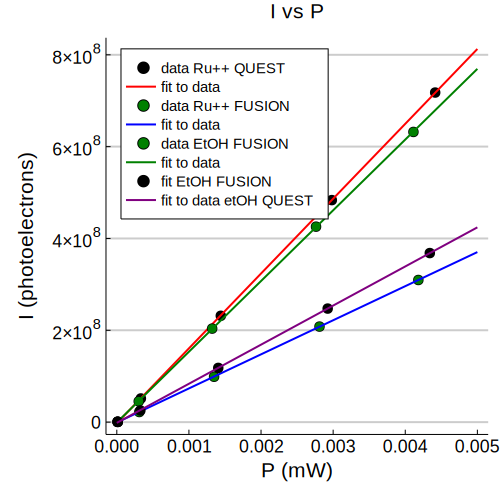

In [936]:
begin
    pru = scatter(rul.power, rul.counts / expTime * qadcpes , label="data Ru++ QUEST",
    shape = :circle, color = :black, markersize = 5, legend=false)
    pru2 = plot!(pru, PP/W, IF, color = :red, lw = 2, label="fit to data",
    linestyle = :solid)
    pru3 = plot!(pru, fusion.power, fusion.counts / sexpTime * adcpes , seriestype= :scatter, label="data Ru++ FUSION",
    shape = :circle, color = :green, markersize = 5, legend=false)
    pru4 = plot!(pru, PP/W, IFF, color = :blue, lw = 2, label="fit to data",
    linestyle = :solid, legend=:topleft)

    pru5 = plot!(pru, fusEtoh.power, fusEtoh.counts / sexpTime * adcpes , seriestype= :scatter, label="data EtOH FUSION",
    shape = :circle, color = :green, markersize = 5, legend=false)
    pru6 = plot!(pru, PP/W, IFFe, color = :green, lw = 2, label="fit to data",
    linestyle = :solid, legend=:topleft)

    pru7 = plot!(pru, quEtoh.power, quEtoh.counts / expTime * qadcpes , seriestype= :scatter, label="fit EtOH FUSION",
    shape = :circle, color = :black, markersize = 5, legend=false)
    pru8 = plot!(pru, PP/W, IFe, color = :purple, lw = 2, label="fit to data etOH QUEST",
    linestyle = :solid, legend=:topleft)

    xlabel!("P (mW)")
    ylabel!("I (photoelectrons)")
    title!("I vs P")
end

In [917]:
dataSlopeqEtoh = coef(qetof)[2] * Hz/W
dataSlope = coef(ruf)[2] * Hz/W
uconvert(Hz/µW, dataSlope - dataSlopeqEtoh)

77850.6434990024 Hz μW⁻¹

In [929]:

dataSlopefEtoh = coef(fetof)[2] * Hz/W
dataSlopeFusion = coef(fuf)[2] * Hz/W
uconvert(Hz/µW, dataSlopeFusion), uconvert(Hz/µW, dataSlopefEtoh)


(74239.27935660566 Hz μW⁻¹, 154023.2740579428 Hz μW⁻¹)

# Model

In [495]:
lfi.LabFbi.Iρ(gl)(1.0mm, 0.0mm)

0.0 Hz cm⁻²

In [836]:
rateqccd = rate_prediction(gl, setup, sset, eff_qccdFilters)
rateccd = rate_prediction(gl, setup, sset, eff_ccdFilters)
rateqccd, rateccd

(1.0653580433829592e8 Hz, 1.1311261340012367e8 Hz)

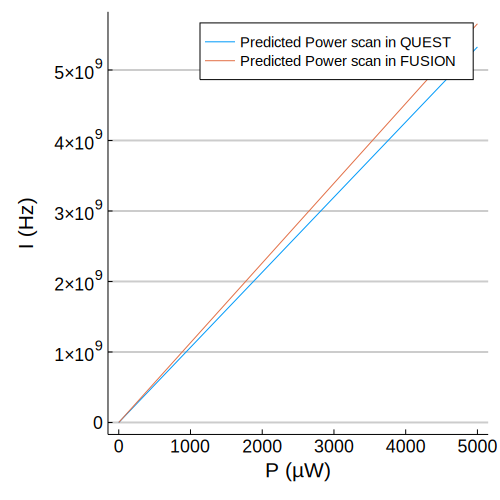

In [837]:
IPq = rate_prediction_power(uconvert.(mW, PP), setup, sset, eff_qccdFilters);
IP = rate_prediction_power(uconvert.(mW, PP), setup, sset, eff_ccdFilters);

pip = plot(PP/µW, IPq/Hz, label="Predicted Power scan in QUEST")
pip2 = plot!(pip, PP/µW, IP/Hz, label="Predicted Power scan in FUSION")
xlabel!("P (µW)")
ylabel!("I (Hz)")


# Compare model to data

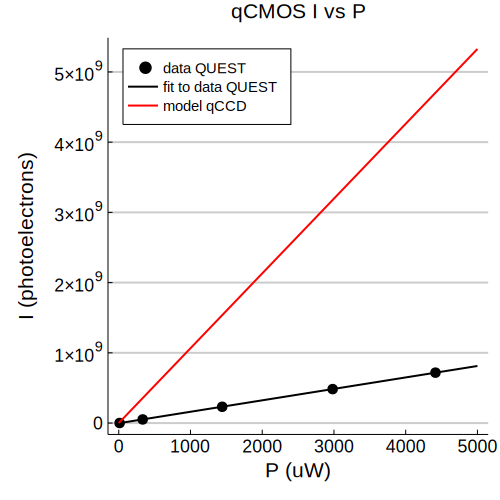

In [925]:
begin
    pru = scatter(uconvert.(µW, rul.power*W)/µW, rul.counts / expTime * qadcpes, label="data QUEST",
                shape = :circle, color = :black, markersize = 5, legend=false)
    pru2 = plot!(pru, PP/μW, IF, color = :black, lw = 2, label="fit to data QUEST",
                linestyle = :solid)
    pru3 = plot!(pru2, PP/µW, IPq/Hz, color = :red, lw = 2, label="model qCCD",
                linestyle = :solid, legend=:topleft)
    xlabel!("P (uW)")
    ylabel!("I (photoelectrons)") 
    title!("qCMOS I vs P")
end

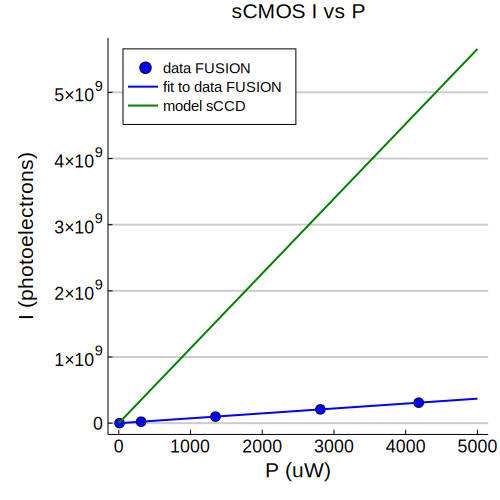

In [926]:
begin
    pfus = scatter(uconvert.(µW, fusion.power*W)/µW, fusion.counts / sexpTime * adcpes, label="data FUSION",
                shape = :circle, color = :blue, markersize = 5)
    pfus2 = plot!(pfus, PP/µW, IFF, color = :blue, lw = 2, label = "fit to data FUSION")
    pfus3 = plot!(pfus2, PP/μW, IP/Hz, color = :green, lw = 2, label="model sCCD",
                linestyle = :solid, legend=:topleft)
    xlabel!("P (uW)")
    ylabel!("I (photoelectrons)") 
    title!("sCMOS I vs P")
end

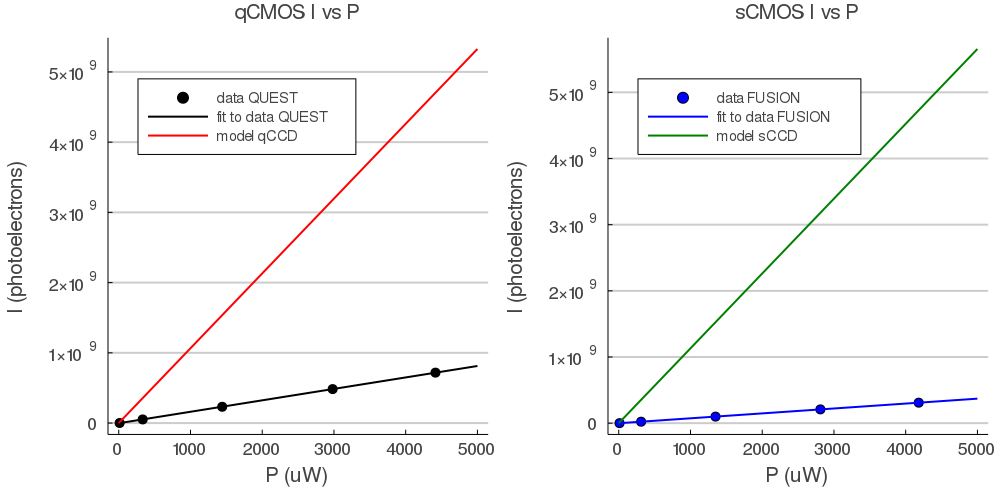

In [927]:
Plots.plot(pru3,pfus3, layout=grid(1,2, widths=[0.5, 0.5]), legend=:topleft, fmt=:png, size=(1000, 500) )

### Model Slope

In [893]:
uconvert(Hz/µW, dataSlope)

83672.83579520525 Hz μW⁻¹

In [919]:
α = asin(ob.NA)
# slope = obga * eff_ccdFilters * fl["l405Ru++"].σ * fl["l405Ru++"].Q * setup.t * setup.c * (1 - exp(-(gl.zr*tan(α)/gl.w0)^2))/ pE 
slope = obga * eff_qccdFilters * fl["l405Ru++"].σ * fl["l405Ru++"].Q * 0.4*mm * setup.c * (1 - exp(-2)) / pE

modelSlope = uconvert(Hz/W, slope)

1.0653580433829594e12 Hz W⁻¹

In [906]:
N_fluo_photon_por_D_por_P = setup.c * fl["l405Ru++"].σ *fl["l405Ru++"].Q * (1-exp(-2)) / pE
uconvert(µJ^-1 * cm^-1, N_fluo_photon_por_D_por_P) 

5.404840572020972e8 μJ⁻¹ cm⁻¹

In [847]:
eff_qccdFilters, obga, fl["l405Ru++"].σ, fl["l405Ru++"].Q

(0.4927795876616403, 0.09999999999999998, 2.0364134107828938e-17 cm², 0.25)

In [924]:
uconvert(Hz / µW , dataSlope - dataSlopeqEtoh)

77850.6434990024 Hz μW⁻¹

In [921]:
modelSlope / (dataSlope - dataSlopeqEtoh)

13.684640171235209

In [928]:
slopef = obga * eff_ccdFilters * fl["l405Ru++"].σ * fl["l405Ru++"].Q * 0.4*mm * setup.c * (1 - exp(-2)) / pE
modelFusionSlope = uconvert(Hz/W, slopef)

1.1311261340012366e12 Hz W⁻¹

In [930]:
modelFusionSlope / (dataSlopeFusion - dataSlopefEtoh)

-14.17735647651495

In [732]:
l = 0.04   # cm
obga * (1-exp(-2)) * l

0.0034586588670535486

In [680]:
Npp = fl["l405Ru++"].σ * fl["l405Ru++"].Q * 2 * gl.zr  * setup.c * (1 - exp(-2)) / pE
uconvert(Hz/µW, Npp)

8.802332174244454e6 Hz μW⁻¹

### Disparity of parameters

In [617]:
qadcpes / adcpes

0.22291666666666668

In [621]:
eff_qccdFilters / eff_ccdFilters

0.9418560948763217

In [632]:
qsensor_size = 22 / 2  * mm     # Rectangular sensor, equivalent inscripted circunference radius
ssensor_size = 13.3 * sqrt(2) / 2 * mm
qsensor_size / ssensor_size

1.1696503147446649

In [638]:
srout_noise = 1.6
qrout_noise = 0.43
srout_noise / qrout_noise

3.72093023255814

In [630]:
sqrt(18.8^2 + 10.6^2)/2, sqrt(2*13.3^2) / 2

(10.791200118615167, 9.404520189781083)

In [522]:
uconvert(µm, gl.zr)

81.43008158104742 μm

In [412]:
gl.w0

0.00324 mm

In [ ]:
pE = lfi.LabFbi.photon_energy(gl.λ)

3.061338232918525 eV

In [ ]:
ga = lfi.LabFbi.geometrical_acceptance(setup.d/mm, setup.D/mm) # * 5 (with lens)

3.995395289030368e-5

In [608]:
obga 

0.09999999999999998

In [662]:
1 - exp(-1), 1 - exp(-2), 1 - exp(-4)

(0.6321205588285577, 0.8646647167633873, 0.9816843611112658)